In [2]:
from PIL import Image
from torchvision import transforms, models
import torch
import torch.nn.functional as F
import torch.nn as nn
import json
import matplotlib.pyplot as plt
import os


class MolePredictor:
    def __init__(self, weights_path, device=None):
        """
        Initializes the predictor.
        """
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Load model
        self.model = models.resnet18(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 3)  # 3 classes
        self.model.load_state_dict(torch.load(weights_path, map_location=self.device))
        self.model = self.model.to(self.device)
        self.model.eval()

        self.idx_to_group = {0: "benign", 1: "suspicious", 2: "melanoma"}
        self.group_map = {
            "melanoma": "melanoma",
            "basal cell carcinoma": "suspicious",
            "actinic keratoses": "suspicious",
            "melanocytic nevi": "benign",
            "benign keratosis-like lesions": "benign",
            "dermatofibroma": "benign",
            "vascular lesions": "benign",
        }

        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )

    def predict(self, image_path, show_image=True):
        """
        Predicts the class of a single mole image and optionally displays it.
        """
        image = Image.open(image_path).convert("RGB")
        input_tensor = self.transform(image).unsqueeze(0).to(self.device)

        with torch.no_grad():
            outputs = self.model(input_tensor)
            probs = F.softmax(outputs, dim=1)
            prob, pred_idx = torch.max(probs, dim=1)

        label = self.idx_to_group[pred_idx.item()]
        probability = prob.item()

        if show_image:
            plt.imshow(image)
            plt.axis("off")
            plt.title(f"{label} ({probability:.2f})")
            plt.show()

        try:
            # Fix the path - annotations are in the ann folder, not with the images
            image_filename = os.path.basename(image_path)
            ann_path = image_path.replace("img", "ann") + ".json"
            # print(f"Looking for annotation at: {ann_path}")

            with open(ann_path, "r") as f:
                ann = json.load(f)
            true_label = ann["objects"][0]["classTitle"]
            true_group_label = self.group_map[true_label]
            extra_text = f" (True: {true_label}), that is {true_group_label}"
            if true_group_label == label:
                extra_text += " - Correct"
            else:
                extra_text += " - Incorrect"
        except Exception as e:
            print(f"Could not load annotation: {e}")
            extra_text = ""

        return (
            f"Prediction: {label}, Probability: {probability:.2f}. {extra_text}",
            label,
            true_label,
            true_group_label,
        )

In [3]:
predictor = MolePredictor("melanoma_model_weights.pth")

files = os.listdir("data/ham10000/ds/img")
from tqdm import tqdm

files_results = {}
count = 0
for file in tqdm(files):
    if file.endswith(".jpg"):
        image_path = os.path.join("data/ham10000/ds/img", file)
        result, label, true_label, true_group_label = predictor.predict(image_path, show_image=False)
        files_results[file] = result, label, true_label, true_group_label
        count = count + 1
        if count > 1000:
            break

c:\Users\major\Documents\University\DeepLearning\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\major\Documents\University\DeepLearning\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 10%|▉         | 1001/10016 [02:17<20:38,  7.28it/s]


In [ ]:
counter = 0
for key, value in files_results.items():
    if value[1] != value[3]:
        print(f"File: {key}, Result: {value}")
        counter = counter + 1
print(f"Total incorrect predictions: {counter} out of {len(files_results)}")

File: ISIC_0024313.jpg, Result: ('Prediction: benign, Probability: 0.99.  (True: melanoma), that is melanoma - Incorrect', 'benign', 'melanoma', 'melanoma')
File: ISIC_0024351.jpg, Result: ('Prediction: benign, Probability: 1.00.  (True: melanoma), that is melanoma - Incorrect', 'benign', 'melanoma', 'melanoma')
File: ISIC_0024400.jpg, Result: ('Prediction: benign, Probability: 0.92.  (True: melanoma), that is melanoma - Incorrect', 'benign', 'melanoma', 'melanoma')
File: ISIC_0024410.jpg, Result: ('Prediction: benign, Probability: 0.96.  (True: melanoma), that is melanoma - Incorrect', 'benign', 'melanoma', 'melanoma')
File: ISIC_0024412.jpg, Result: ('Prediction: suspicious, Probability: 0.85.  (True: benign keratosis-like lesions), that is benign - Incorrect', 'suspicious', 'benign keratosis-like lesions', 'benign')
File: ISIC_0024422.jpg, Result: ('Prediction: suspicious, Probability: 0.84.  (True: benign keratosis-like lesions), that is benign - Incorrect', 'suspicious', 'benign k

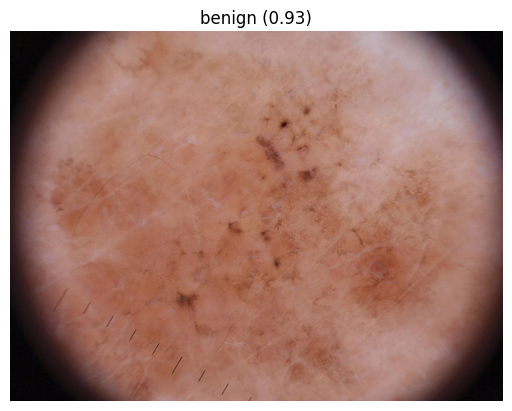

Prediction: benign, Probability: 0.93.  (True: melanoma), that is melanoma - Incorrect


In [ ]:
image_path = os.path.join("data/ham10000/ds/img", "ISIC_0024644.jpg")
result, label, true_label, true_group_label = predictor.predict(image_path, show_image=True)
print(result)